### Build a Function to do Pre-processing

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Function for preprocessing
def flightDataPreprocess(trainData, testData, targetCol, dropFirst=True, binDistance=[0, 2400, 15000], binAge=[0, 14, 24, 44, 54, 64, 100]):
    
    """
    ## Meaning of parameters
    trainData: training data in dataframe
    testData: testing data in dataframe
    targetCol: column name to us as target
    dropFirst: drop first column when doing one-hot encoding
    binDistance: bin margin of Flight distance when doing k-bins discretization
    binAge: bin margin of Age distance when doing k-bins discretization

    ## Return variables
    trainCopy: training data after pre-processing
    testCopy: testing data after pre-processing
    trainTarget: targets of training data
    testTarget: targets of testing data
    """

    trainCopy = trainData.copy()
    testCopy = testData.copy()

    trainTarget = trainData.loc[:, targetCol]
    testTarget = testData.loc[:, targetCol]

    trainCopy.drop(targetCol, axis=1, inplace=True)
    testCopy.drop(targetCol, axis=1, inplace=True)

    # 310 nan in "Arrival Delay in Minutes" and is highly correlaiton with "Departure Delay in Minutes"
    trainCopy.drop("Arrival Delay in Minutes", axis=1, inplace=True)
    testCopy.drop("Arrival Delay in Minutes", axis=1, inplace=True)
    
    # Standardize numerical variables
    numVar = ["Departure Delay in Minutes"]
    trainCopy[numVar] = StandardScaler().fit_transform(trainCopy[numVar])
    testCopy[numVar] = StandardScaler().fit_transform(testCopy[numVar])

    # Discretize continuous variables
    binA = binAge  # Can cutomize the bin edge of Age
    binD = binDistance  # Can cutomize the bin edge of Flight Distance

    trainCopy["Age"] = pd.cut(trainCopy["Age"], binA).cat.codes
    testCopy["Age"] = pd.cut(testCopy["Age"], binA).cat.codes

    trainCopy["Flight Distance"] = pd.cut(trainCopy["Flight Distance"], binD).cat.codes
    testCopy["Flight Distance"] = pd.cut(testCopy["Flight Distance"], binD).cat.codes

    # One-hot encoding nominal variables
    nomiVar = ["Gender", "Customer Type", "Type of Travel", "Class"]

    trainDummy = pd.get_dummies(trainCopy[nomiVar], drop_first=dropFirst)
    trainCopy = trainCopy.merge(trainDummy, left_index=True, right_index=True)
    trainCopy.drop(nomiVar, axis=1, inplace=True)

    testDummy = pd.get_dummies(testCopy[nomiVar], drop_first=dropFirst)
    testCopy = testCopy.merge(testDummy, left_index=True, right_index=True)
    testCopy.drop(nomiVar, axis=1, inplace=True)

    return trainCopy, testCopy, trainTarget, testTarget

# trainFil, testFil, trainTarget, testTarget = flightDataPreprocess(trainData = train, testData = test, targetCol="satisfaction")


### Correlation between variables

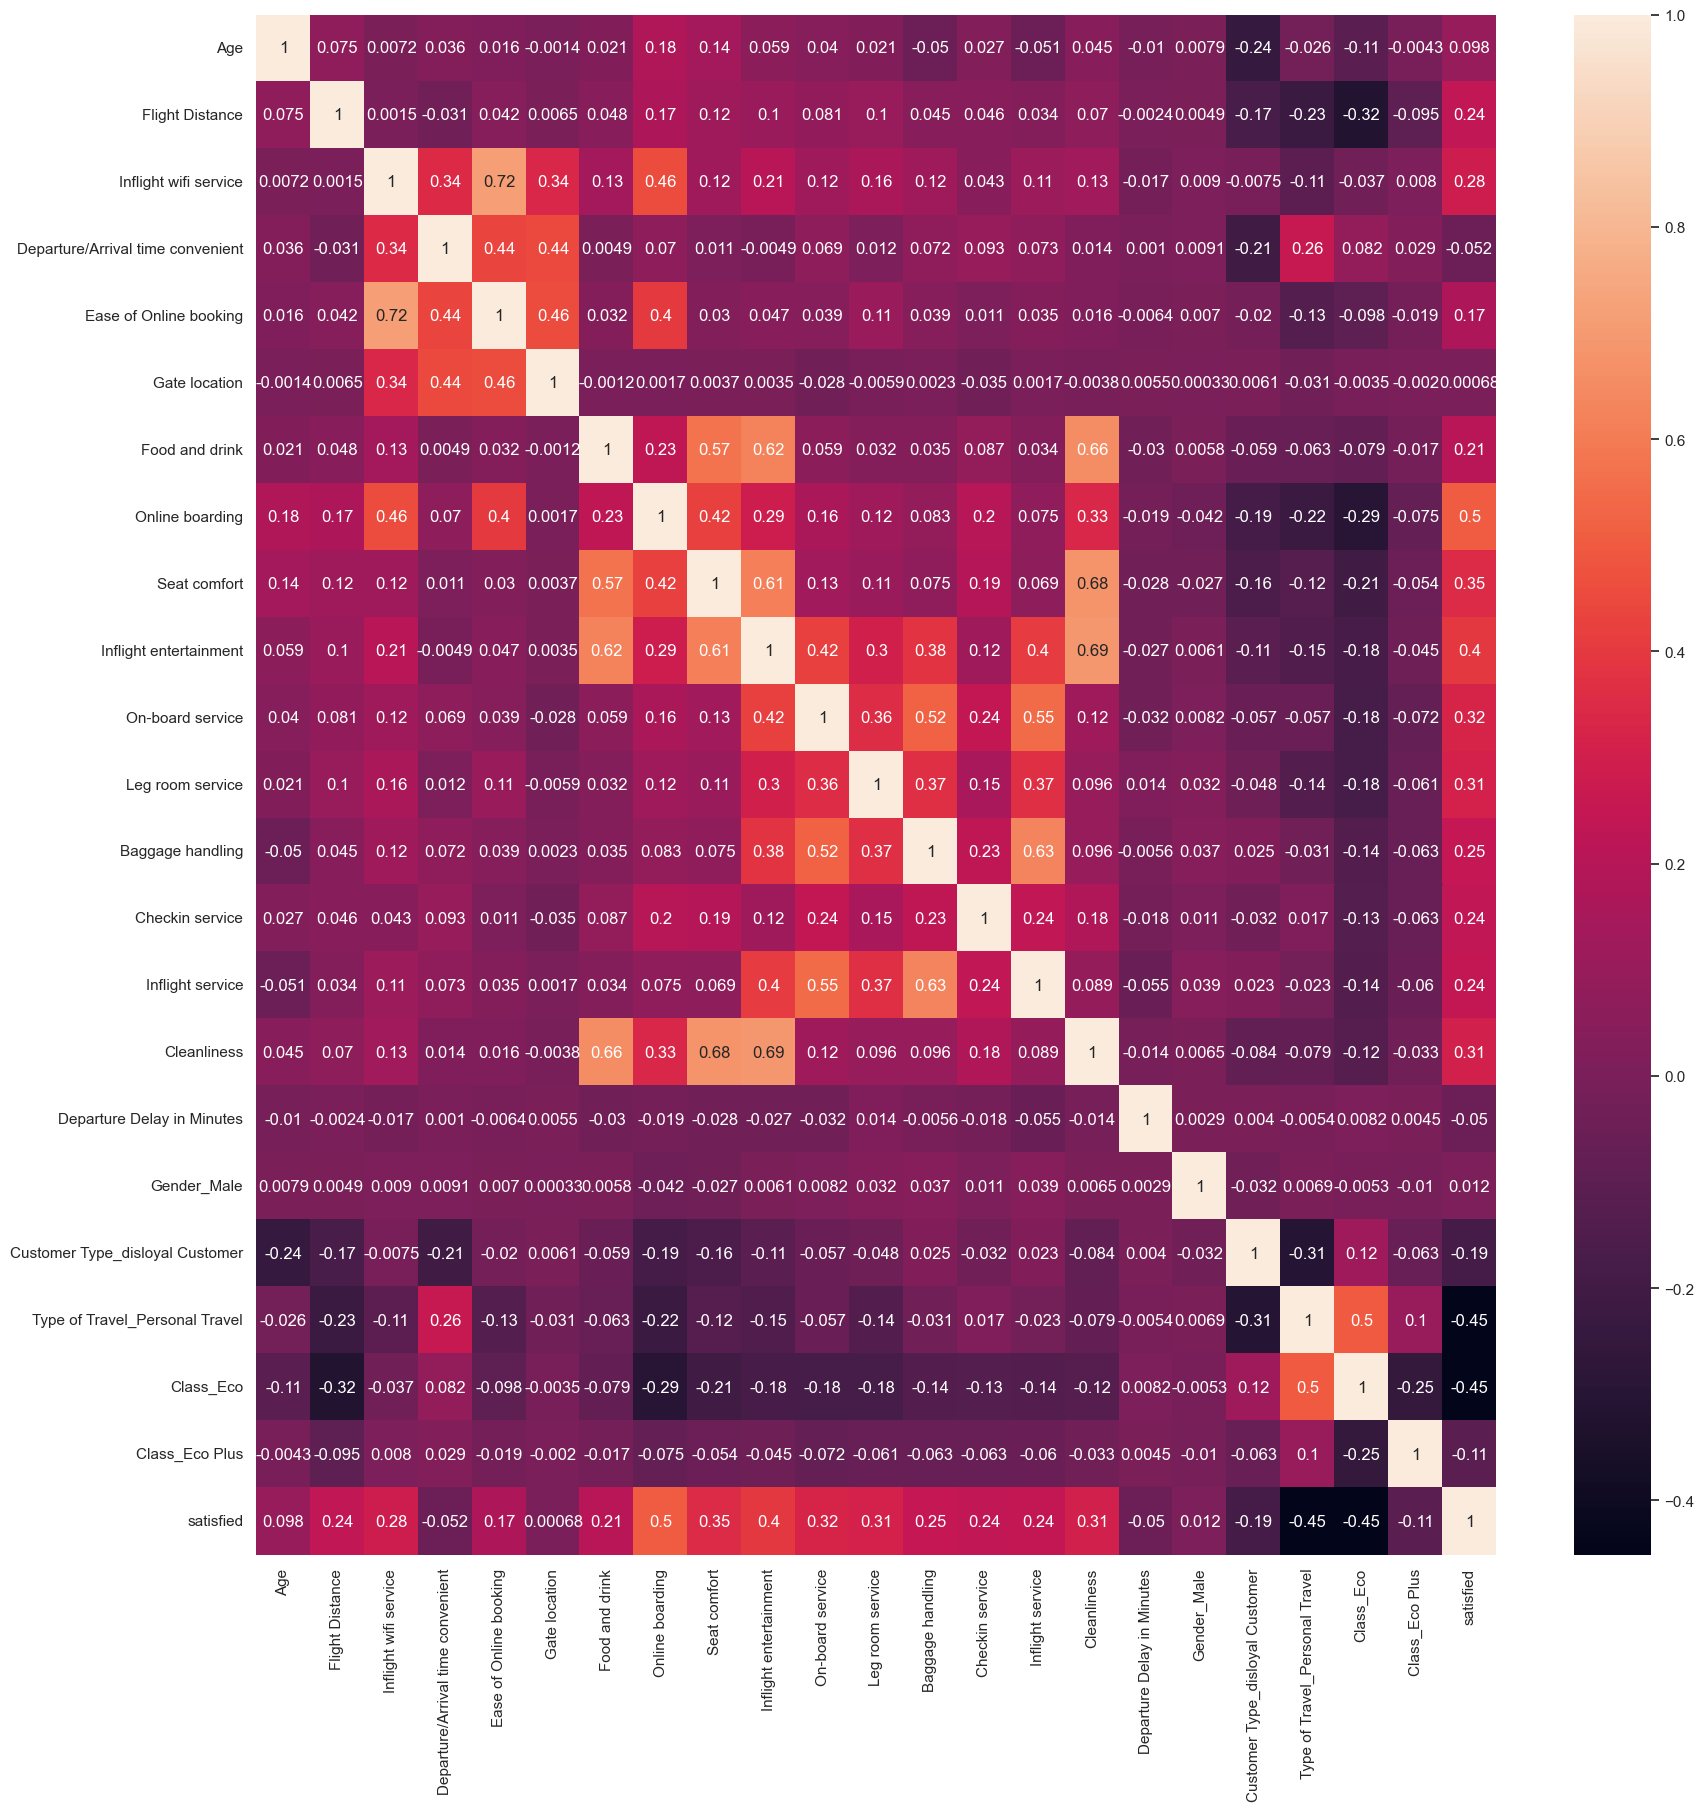

In [2]:
import matplotlib.pyplot as plt
import seaborn as sn

# Load Data
train = pd.read_csv("train.csv", index_col="id")
test = pd.read_csv("test.csv", index_col="id")
train, test, trainTarget, testTarget = flightDataPreprocess(trainData = train, testData = test, targetCol="satisfaction", binDistance=[0,2500,15000])

trainTarget4Corr = pd.get_dummies(trainTarget, drop_first=True)
train4Corr = train.merge(trainTarget4Corr, left_index=True, right_index=True)

corrMatrix = train4Corr.corr()
sn.set(rc = {"figure.figsize":(20, 20)})
sn.heatmap(corrMatrix, annot=True)
plt.show()

### Choose only Important variables

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

train = pd.read_csv("train.csv", index_col="id")
test = pd.read_csv("test.csv", index_col="id")
train, test, trainTarget, testTarget = flightDataPreprocess(trainData = train, testData = test, targetCol="satisfaction", binDistance=[0,2500,15000])

thresCorr = dict()
for n in range(0, 6):
    corr  = n/10  # real correlation threshold  # How high the correlation to be important variables
    print(corr)
    
    filImportant = abs(corrMatrix.loc["satisfied", :]) >= corr
    importantVar = corrMatrix.columns[filImportant].drop("satisfied")
    trainImportant = train.loc[:, importantVar]
    testImportant = test.loc[:, importantVar]

    # KNeighborsClassifier
    kNeighbor = []
    accTrend = []
    for n in range(1, 16):
        print(n)
        knn = KNeighborsClassifier(n_neighbors=n).fit(trainImportant, trainTarget)
        pred = knn.predict(testImportant)
        eva = classification_report(y_true=testTarget, y_pred=pred, output_dict=True)
        kNeighbor.append(n)
        accTrend.append(eva["accuracy"])
        print(eva["accuracy"])

    dictCorr = {"x":kNeighbor, "y":accTrend}
    thresCorr[str(corr)] = dictCorr


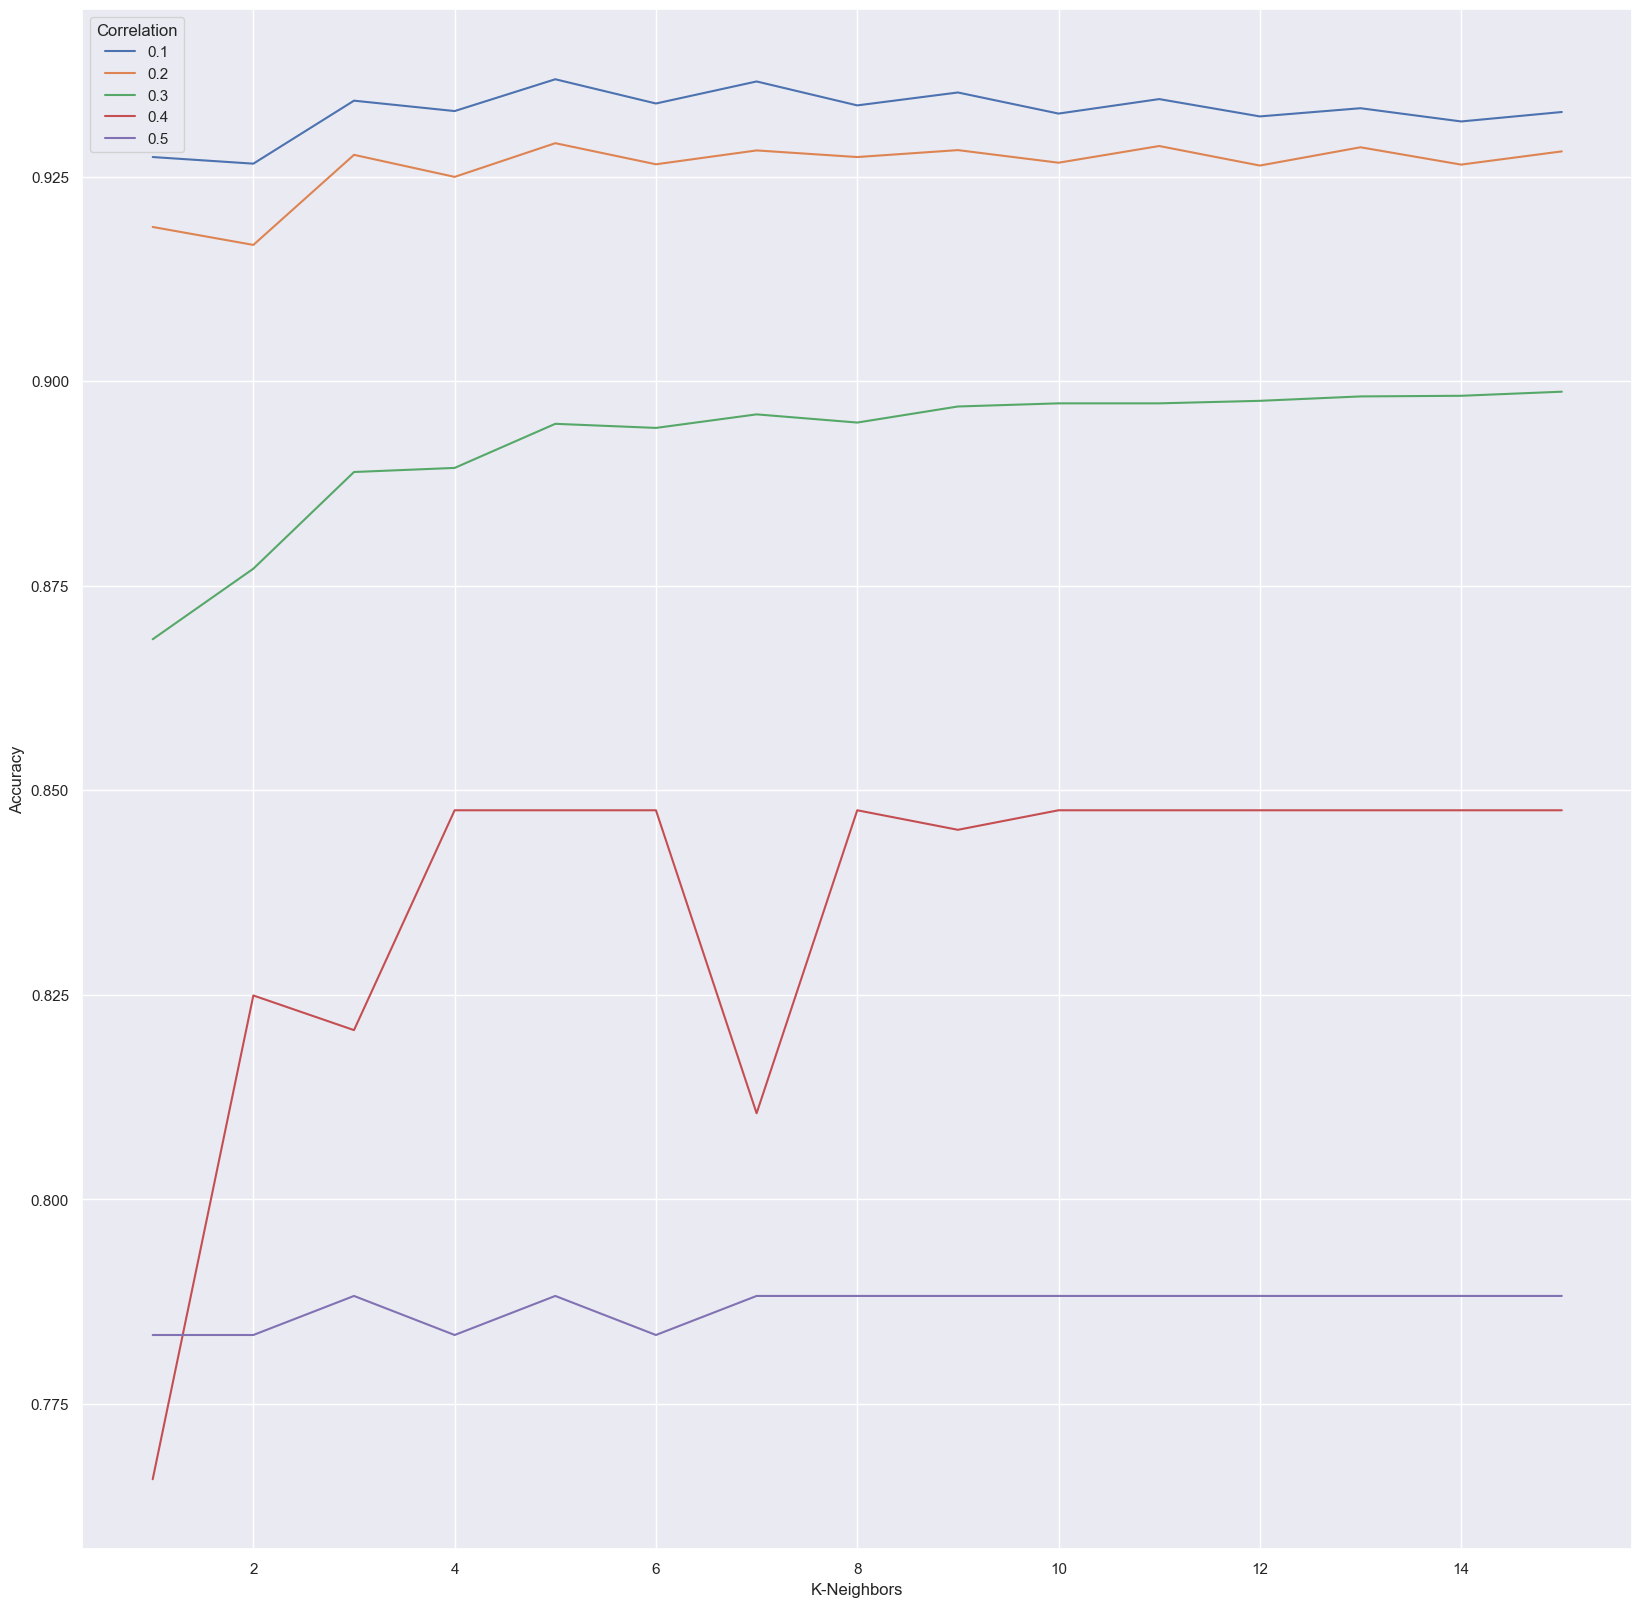

In [5]:
import matplotlib.pyplot as plt

# Plot the result
for corr in range(0, 6):
    plt.plot(thresCorr[str(corr/10)]["x"], thresCorr[str(corr/10)]["y"], label = str(corr/10))

plt.rcParams["figure.figsize"] = (8, 6)  
plt.xlabel("K-Neighbors")
plt.ylabel("Accuracy")
plt.legend(title="Correlation")
plt.show()

### For-Loop of Different Flight Distance

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Load Data
train = pd.read_csv("train.csv", index_col="id")
test = pd.read_csv("test.csv", index_col="id")

thresD = dict()
for d in range(500, 4000, 500):
    print(d)
    binDistance = [0, d, 15000]
    trainFil, testFil, trainTarget, testTarget = flightDataPreprocess(trainData = train, testData = test, targetCol="satisfaction", binDistance=binDistance)
    trainFilCopy = trainFil.copy()
    testFilCopy = testFil.copy()

    # KNeighborsClassifier
    kNeighbor = []
    accTrend = []
    for n in range(1, 51):
        print(n)
        knn = KNeighborsClassifier(n_neighbors=n).fit(trainFilCopy, trainTarget)
        pred = knn.predict(testFilCopy)
        eva = classification_report(y_true=testTarget, y_pred=pred, output_dict=True)
        kNeighbor.append(n)
        accTrend.append(eva["accuracy"])

    dictn = {"x":kNeighbor, "y":accTrend}
    thresD[str(d)] = dictn


### Plot the Result of Evaluation Under different Flight Distance

In [ ]:
import matplotlib.pyplot as plt

for d in range(500, 4000, 500):
    plt.plot(thresD[str(d)]["x"], thresD[str(d)]["y"], label = str(d))
    
plt.rcParams["figure.figsize"] = (8, 6)  
plt.xlabel("K-Neighbors")
plt.ylabel("Accuracy")
plt.legend()
plt.show()